# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3: 
## Build a classifier that assigns a card type to a time series based on time series features


Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/GEOP/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


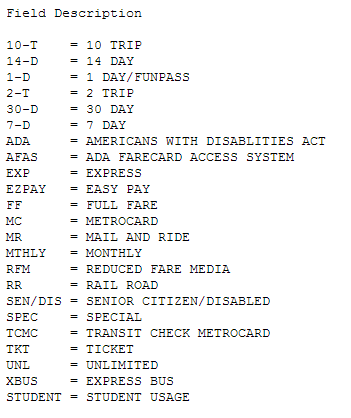

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

In [2]:
# read in data
mta = np.load("MTA_Fare.npy")
#number of time stamps
N = mta.shape[2]

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


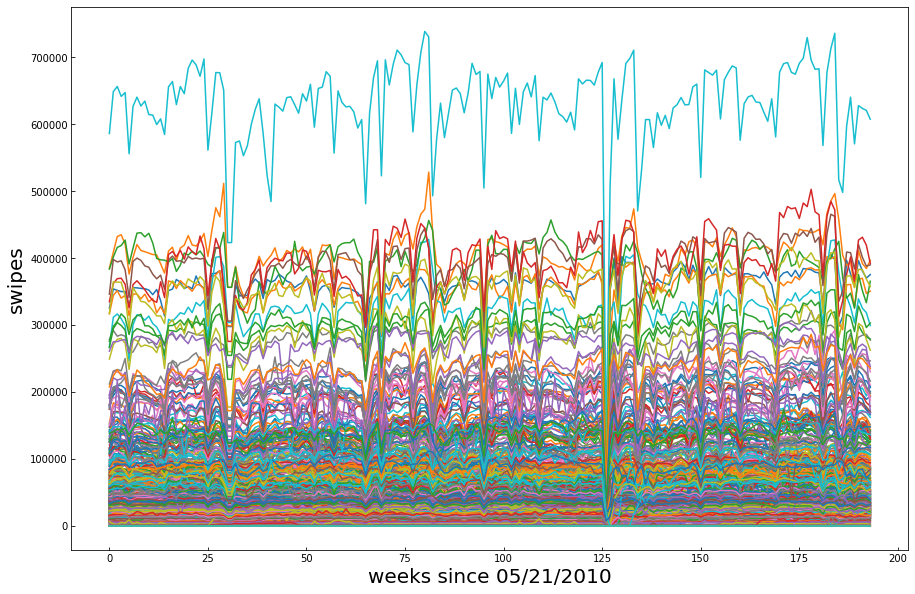

In [5]:
#plot data
pl.figure(figsize=(15,10))
#loop over stations
for i in range(mta.shape[0]):
    allrides = [sum(mta[i,:,j]) for j in range(mta.shape[2])]
    pl.plot(allrides)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
tmp = pl.ylabel("swipes", fontsize=20)  

#### Figure 1: time series of MTA weekly subway swipes for 194 weeks starting on 05/23/2010 for all stations, for any ticket type (summed over all ticket types)

In [6]:
#create time range based on metadata
rng = pd.date_range('05/25/2010', periods=N, freq='W')
print ("nominal date range given the metadata\n", rng)

nominal date range given the metadata
 DatetimeIndex(['2010-05-30', '2010-06-06', '2010-06-13', '2010-06-20',
               '2010-06-27', '2010-07-04', '2010-07-11', '2010-07-18',
               '2010-07-25', '2010-08-01',
               ...
               '2013-12-08', '2013-12-15', '2013-12-22', '2013-12-29',
               '2014-01-05', '2014-01-12', '2014-01-19', '2014-01-26',
               '2014-02-02', '2014-02-09'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')


In [ ]:
# plot data in log space (may take a while to plot because of the very inefficient double for loop - 
#the counter needs to get to 23)
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
mta = mta.astype(float)
mta[mta == -1] = float('NaN')
logrides = np.log10(mta)
for j in range(mta.shape[1]):
    #the next 2 lines of code set up a rolling counter in the window
    print (j+1,"/23")
    clear_output(wait=True)
    for i in range(mta.shape[0]):
        pl.plot(logrides[i,j])
pl.xticks(rotation = 75, fontsize=20)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel("swipes (log10)", fontsize=20)      ;   

22 /23


#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 

## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.

if the event is in all time series then I can work with the mean, or the sum of the time series to find it. That will smooth over the noise and keep the significance of the event (**if** the event is in all time series!)

In [7]:
mta_allsum = np.nansum(mta, axis=0)
print ("mta array collapsing station axis:", mta_allsum.shape)
mta_allsum = np.nansum(mta_allsum, axis=0)
print ("mta array collapsing ride type and station axes:", mta_allsum.shape)

mta array collapsing station axis: (23, 194)
mta array collapsing ride type and station axes: (194,)


In [8]:
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]

Find the most significant event by 3-sigma thresholding 

3 sigma threshold 20825898.6
outlier index (array([126]),)
outlier date DatetimeIndex(['2012-10-28'], dtype='datetime64[ns]', freq=None)


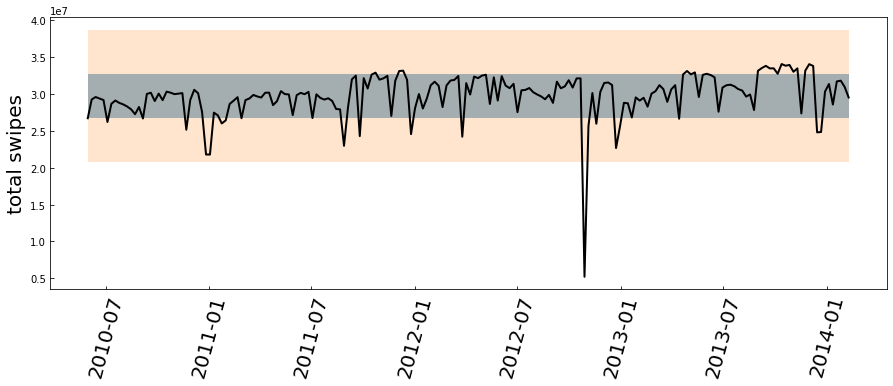

In [9]:
#plot all swipes
pl.figure(figsize=(15,5))
onesig = np.std(mta_allsum)
tsthresh = np.nanmean(mta_allsum)  - 3 * onesig
print ("3 sigma threshold %.1f"%tsthresh)
print ("outlier index", np.where(mta_allsum < tsthresh))
print ("outlier date", rng[np.where(mta_allsum < tsthresh)])
pl.fill_between(d, np.nanmean(mta_allsum) - onesig,
                np.nanmean(mta_allsum) + onesig, alpha=0.5)
pl.fill_between(d, np.nanmean(mta_allsum) - 3 * onesig,
                 np.nanmean(mta_allsum) + 3 * onesig, alpha = 0.2)
#pl.fill_between(weighted +threesigma(weighted , 10), weighted -threesigma(weighted 
pl.plot(d, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  ;


#### Figure 3a: The sum  of the number of all MTA swipe time series, with corrected timeline: the time range covers 194 weeks starting on 2010-05-19 as confirmed by the most significant drop in ridership aligning with Hurricane Sandy (10/22/2012), in the week of 2012-10-29, when MTS shut down for several days.

# The outlier is near the date of Hurricane Sandy.

A  more representative way to show this is to plot the weighted average of all rides, weighted by ticket popularity

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


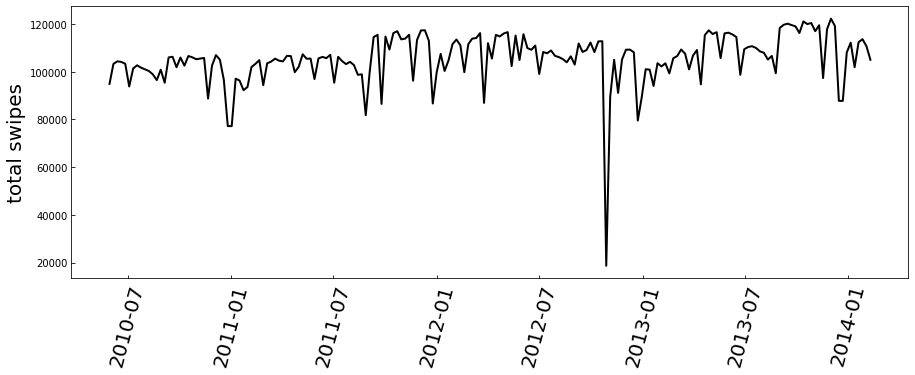

In [10]:
weightedrides = np.zeros((mta.shape[0], mta.shape[2]))

for i in range(mta.shape[0]):
    allrides = np.array([np.nansum(mta[i,:,j].flatten()) for j in range(mta.shape[2])])
    #print (allrides/nanmean(allrides)).shape, weightedrides.shape
    weightedrides[i] = allrides / np.sqrt(nanmean(allrides))
    #pl.plot(rng, np.log10(weightedrides[i]))
    #pl.xticks(rotation = 75)

    
#plot weighted by station, per ride
pl.figure(figsize=(15,5))
pl.plot(d, np.nansum(weightedrides, axis=0), 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
rides = pd.DataFrame({'t':rng, 'ridecounts':np.nansum(weightedrides, axis=0)})

#### Figure 3: time series for all rides weighted by mean number of rides per ticket type in semi-log space

 # 2: finding trends

### find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking ofr something that has a more or less constant trend

## to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per type. 

## you can use a rolling mean for smoothing, you can use the ratio of the number of swipes near the beginning and the end if the time series, or fit a line to the time series and get its slope.  find series with the steepest upward trend, and the steepest downward trend.

## notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


Since I am asked to find which ticket type has a steady increase in popularity, I will use the average across all stations

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


stdev 519705.73, fractional increase over time 1.07: 
stdev 62962.10, fractional increase over time 1.34: 
stdev 5484.34, fractional increase over time 1.18: 
stdev 8200.05, fractional increase over time 0.98: 
stdev 3471.64, fractional increase over time 1.08: 
stdev 614851.57, fractional increase over time 1.47: 
stdev 448552.87, fractional increase over time 0.93: 
stdev 3658.04, fractional increase over time 0.00: 
stdev 96197.57, fractional increase over time 0.00: 
stdev 198767.71, fractional increase over time 0.00: 
stdev 17745.48, fractional increase over time 0.89: 
stdev 24129.44, fractional increase over time 1.27: 
stdev 58579.27, fractional increase over time 28209.44: 
stdev 16498.07, fractional increase over time 0.60: 
stdev 145035.47, fractional increase over time 0.66: 
stdev 32495.16, fractional increase over time 2.67: 
stdev 17795.06, fractional increase over time 2.97: 
stdev 4524.89, fractional increase over time 67.96: 
stdev 29496.85, fractional increase over 

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


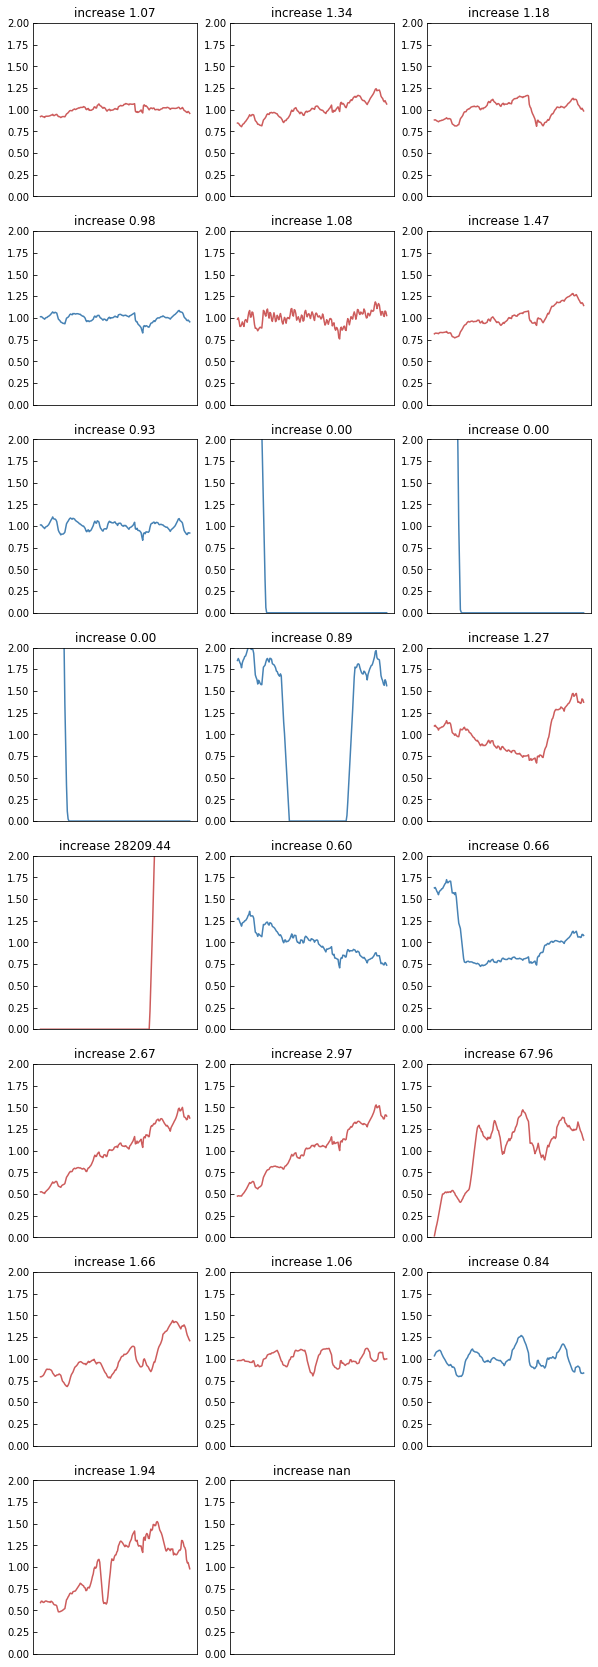

In [12]:
#remove series w bad data and store the rest in a new array
mtanew = np.empty_like(mta)
for i,m in enumerate(mta):
    for j,t in enumerate(m):
        if not -1 in t:
            mtanew[i][j] = t
mta = mtanew

increase = np.zeros((mta.shape[1],2))
fig = pl.figure(figsize=(10,30))


for i in range(mta.shape[1]):
    mta_allsum = mta[:,i,:]
    ax = fig.add_subplot(8,3,i+1)
    #rolling mean of rides by type
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    increase[i] = np.array([np.nanstd(thisride), 
                   np.nanmean(thisride[-10:]) / np.nanmean(thisride[:10])])
    print ("stdev {0:.2f}, fractional increase over time {1:.2f}: ".format(increase[i][0], 
                                                                            increase[i][1]))
    if increase[i][1] > 1:
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed")
    else: 
        pl.plot(thisride / np.nanmean(thisride), color="SteelBlue")
    pl.ylim(0,2)
    pl.xticks([])
    pl.title("increase %.2f"%(increase[i][1]))
        


#### Figure 4a: time series smoothed (rolling mean w window 10), normalized,  in semi-log space. In red are possibly increasing trends (ratio of beginning to end of the time series >1)

order of increasing trend magnitude: [22 12 17 16 15 21 18  5  1 11  2  4  0 19  3  6 10 20 14 13  7  8  9]
corresponding stdev: [0.00000000e+00 5.85792724e+04 4.52489475e+03 1.77950603e+04
 3.24951624e+04 2.52041044e+02 2.94968451e+04 6.14851567e+05
 6.29621004e+04 2.41294380e+04 5.48433683e+03 3.47164240e+03
 5.19705730e+05 1.57054506e+03 8.20005208e+03 4.48552874e+05
 1.77454822e+04 6.81417013e+02 1.45035465e+05 1.64980720e+04
 3.65803859e+03 9.61975736e+04 1.98767713e+05]


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  


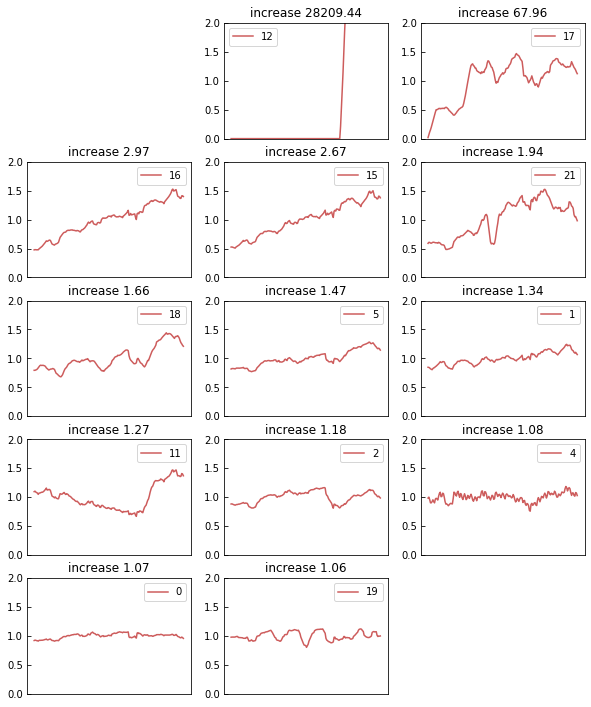

In [13]:
#printing the increase sorted
fig = pl.figure(figsize=(10,20))
trendsort = np.argsort(increase[:,1])[::-1]
print ("order of increasing trend magnitude:", trendsort)
print ("corresponding stdev:", increase[trendsort,0])
for j, i in enumerate(trendsort):
    mta_allsum = mta[:,i,:]
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    if increase[i][1] > 1:
        ax = fig.add_subplot(8,3,j+1)
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed", label="%d"%i)
    else: 
        continue
    pl.ylim(0,2)
    pl.title("increase %.2f"%(increase[i][1]))
    pl.legend()
        
    pl.xticks([])


#### Figure 4b: As Figure 4a, but only the time series with increasing trends are plotted, in descending order of increase magnitude (caluclated as ratio of beginning to end of the time series averaged over 10 time stapms)

# if my data is small ~20 time series, why not just looking at it! (think about the assigned reading) 
# the first smooth trend is for ride type at index 16 (by visual inspection)

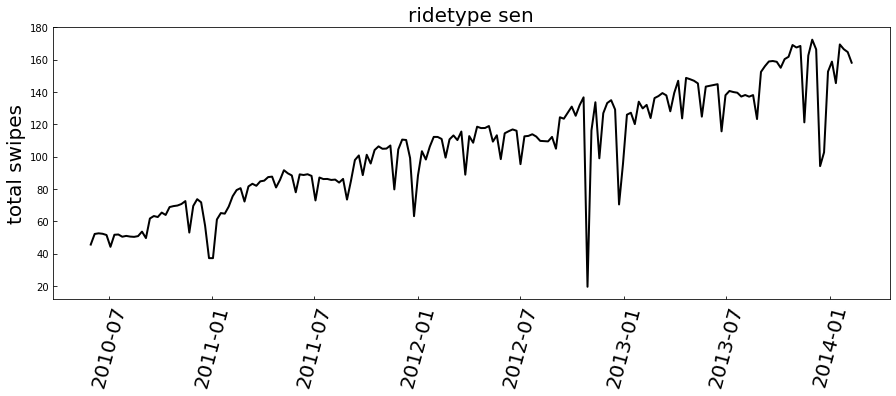

In [14]:
# plot the most evident trend: senior tickets
mtabyride = np.nanmean(mta, axis=0)
pl.figure(figsize=(15,5))
pl.plot(d, mtabyride[16], 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
title = pl.title ("ridetype " + ridetype[16], fontsize=20)

#### Figure 4c: the steepest smooth increase in ridership type is for Senior passes. Above is the average over all station of the senior pass popularity

In [15]:
# a more rigorous way to find the most significant, smooth increasing trend, is by fitting a line to the data
import statsmodels.api as sm
from statsmodels.stats.gof import chisquare
models = []
selectedIndeces = [17,16,15]
for i in selectedIndeces:
    models.append(sm.OLS(mtabyride[i], 
                         sm.add_constant(np.arange(mta.shape[2]))).fit())
    #(np.nanmean(mta, axis=0)[16])
for i,m in enumerate(models):
    print (selectedIndeces[i], "R^2 line fit %.2f"%m.rsquared)

17 R^2 line fit 0.43
16 R^2 line fit 0.82
15 R^2 line fit 0.80


# the fit to a straight line is best for index 16 as well, confirming that Senior rides have the steepest continuous increase among ride types 

# Build  models that classified the *ride type* based on the time series characteristics using random forests. 

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model 



## Build one that uses as input features the following engineered features :
- the time series mean divided by the mean of all time series for that station
- the time series standard deviation by the  standard deviation of all time series for that station
- the slope and intercept of a line fit to the standardized time series 
        (time_series - time_series.mean())/time_series.std()
        

you will have to remove time series containing NaN because the random forest sklearn implementation does not work with NaNs. 
An easy way to do that is to remove all time series whose standard deviation is NaN



In [16]:
stationsmeans = np.nanmean(np.nanmean(mta, axis=1),axis=1)
stationsmeans.shape

(600,)

In [17]:
stationsstd = np.nanstd(np.nanstd(mta, axis=1), axis=1)
stationsstd.shape

(600,)

In [18]:
stationid = np.concatenate([np.array([i] * 23) for i in range(600)])
stationid[mta.reshape(600*23, 194).std(1) > 0]

array([  2,   2,   2, ..., 550, 550, 550])

In [19]:
tots = mta.reshape(600*23, 194)[mta.reshape(600*23, 194).std(1) > 0]
tots.shape

(7660, 194)

In [20]:
normedtsmean = [np.nanmean(tots[i]) / stationsmeans[stationid[i]] for i in range(len(tots))]
normedtsstd = [np.nanstd(tots[i]) / stationsstd[stationid[i]] for i in range(len(tots))]


//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [21]:
normedtsstd[:10]

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]

In [22]:
normedtsmean[0]

inf

In [23]:
label = list(range(23)) * 600
label = np.array(label)[mta.reshape(600*23, 194).std(1)>0]
label.shape

(7660,)

In [24]:
label[:26]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       18,  0,  1,  2,  3,  4,  5,  6,  7])

In [25]:
tsmean = np.nanmean(tots, axis=1)
tsmean.shape



(7660,)

In [26]:
tsmean[:10]

array([3.54891753e+03, 1.44587629e+02, 1.79381443e+01, 3.02577320e+01,
       2.89690722e+00, 1.72666495e+03, 1.25873711e+03, 3.86597938e-01,
       4.62886598e+00, 3.00618557e+01])

In [27]:
tsstdev = np.nanstd(tots, axis=1)


Text(0, 0.5, 'standardized number of rides')

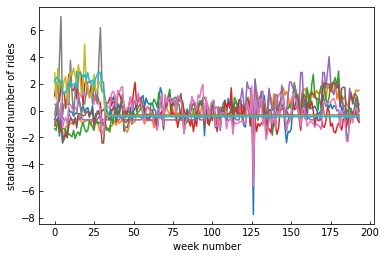

In [28]:
standardizedts = np.array([(ts - tsmean[i]) / tsstdev[i] for i,ts in enumerate(tots)])
for i in range(10):
    pl.plot(standardizedts[i])
pl.xlabel("week number")
pl.ylabel("standardized number of rides")

In [29]:
# fit the standardized time series (you could argue you should fit the non standardized ones)
allfits = []
for ts in standardizedts:
    allfits.append(sm.OLS(ts, 
                         sm.add_constant(np.arange(194))).fit())


In [30]:
len(allfits), tsmean.shape[0], tsstdev.shape[0]


(7660, 7660, 7660)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normedtsmean, normedtsstd]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

In [32]:
(~np.isfinite(X_train)).sum(),(~np.isfinite(X_test)).sum(),(~np.isfinite(y_train)).sum(),(~np.isfinite(y_test )).sum()

(870, 418, 0, 0)

In [33]:
X_train[~np.isfinite(X_train)] = X_train[np.isfinite(X_train)].mean()

In [34]:
X_test[~np.isfinite(X_test)] = X_test[np.isfinite(X_test)].mean()

In [35]:
X_train[:,0]

array([-0.65195848,  1.11408791,  1.01699379, ...,  1.10918101,
       -0.71354735,  1.13612208])

In [36]:
X_train[:,1]

array([ 0.00675605, -0.01154495, -0.0105388 , ..., -0.0114941 ,
        0.00739427, -0.01177329])

In [37]:
X_train[:,2]

array([ 1.06938406,  0.02836795,  0.10374375, ...,  1.06540129,
       16.53794756,  0.22582894])

In [38]:
X_train[:,3]

array([ 0.87068366,  0.22510688,  0.1255867 , ...,  5.22127231,
       17.69811   ,  0.30241717])

In [39]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [40]:
y_pred = clf.predict(X_test)


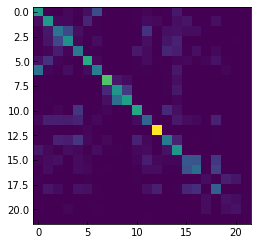

In [41]:
imshow(confusion_matrix(y_test, y_pred))

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.48      0.58      0.53       135
        14d       0.50      0.59      0.54       133
         1d       0.39      0.37      0.38       148
         2t       0.49      0.49      0.49       147
        30d       0.40      0.47      0.43       124
         7d       0.66      0.62      0.64       144
        ada       0.53      0.44      0.48       142
       afas       0.78      0.83      0.81       126
        exp       0.55      0.60      0.57       125
         ez       0.74      0.57      0.65       143
         ff       0.70      0.64      0.66       137
         mc       0.39      0.34      0.36       138
         mr       0.86      0.97      0.91       149
      month       0.50      0.40      0.45       146
        rfm       0.41      0.64      0.50       119
         rr       0.35      0.28      0.31       138
        sen       0.41      0.36      0.38       142
       spec       0.29      0.17      0.22   

//anaconda/envs/GEOP/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


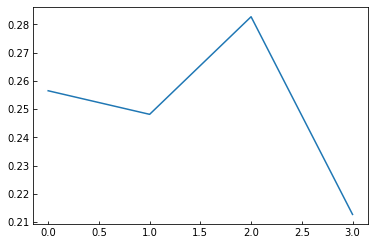

In [43]:
pl.plot(clf.feature_importances_)

In [44]:
from sklearn import preprocessing
inputFeatures =     np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], 
              normedtsmean, normedtsstd]).T

inputFeatures

array([[-9.41656187e-03,  9.75809520e-05,             inf,
                    inf],
       [-1.45472894e+00,  1.50749113e-02,             inf,
                    inf],
       [-1.06906758e+00,  1.10784205e-02,             inf,
                    inf],
       ...,
       [-8.30556635e-02,  8.60680451e-04,  1.04578175e-05,
         5.85277692e-04],
       [-1.16167013e+00,  1.20380324e-02,  1.06859373e+00,
         1.94659637e+00],
       [-8.66474156e-01,  8.97900680e-03,  1.14116606e-01,
         1.25099942e-01]])

In [45]:
inputFeatures[np.isinf(inputFeatures)] = np.nan

In [46]:
inputFeaturesWhitened = preprocessing.imputation.Imputer(strategy="median").fit(inputFeatures).transform(inputFeatures)
inputFeaturesWhitened

array([[-9.41656187e-03,  9.75809520e-05,  4.76289688e-02,
         7.93387640e-02],
       [-1.45472894e+00,  1.50749113e-02,  4.76289688e-02,
         7.93387640e-02],
       [-1.06906758e+00,  1.10784205e-02,  4.76289688e-02,
         7.93387640e-02],
       ...,
       [-8.30556635e-02,  8.60680451e-04,  1.04578175e-05,
         5.85277692e-04],
       [-1.16167013e+00,  1.20380324e-02,  1.06859373e+00,
         1.94659637e+00],
       [-8.66474156e-01,  8.97900680e-03,  1.14116606e-01,
         1.25099942e-01]])

In [47]:
np.isnan(inputFeaturesWhitened).sum()

0

In [48]:
X_train, X_test, y_train, y_test = train_test_split(inputFeaturesWhitened,
    label, test_size=0.33, random_state=42, shuffle=True)

In [49]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
y_pred = clf.predict(X_test)


In [51]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.46      0.54      0.50       135
        14d       0.49      0.55      0.52       133
         1d       0.35      0.32      0.34       148
         2t       0.50      0.51      0.51       147
        30d       0.38      0.47      0.42       124
         7d       0.68      0.62      0.65       144
        ada       0.48      0.48      0.48       142
       afas       0.76      0.82      0.79       126
        exp       0.53      0.66      0.59       125
         ez       0.73      0.56      0.63       143
         ff       0.69      0.61      0.65       137
         mc       0.34      0.31      0.32       138
         mr       0.85      0.97      0.91       149
      month       0.47      0.38      0.42       146
        rfm       0.56      0.58      0.57       119
         rr       0.32      0.26      0.29       138
        sen       0.39      0.32      0.35       142
       spec       0.27      0.31      0.29   

//anaconda/envs/GEOP/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))
//anaconda/envs/GEOP/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Build one that uses as input features each time stamp (194 features) :


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    standardizedts, label, test_size=0.33, random_state=42, shuffle=True)

In [53]:
label.shape

(7660,)

In [54]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

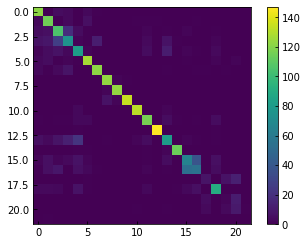

In [55]:
y_pred = clf.predict(X_test)
zx = imshow(confusion_matrix(y_test, y_pred))
pl.colorbar()

In [56]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.77      0.90      0.83       135
        14d       0.71      0.86      0.78       133
         1d       0.61      0.72      0.66       148
         2t       0.56      0.51      0.54       147
        30d       0.59      0.66      0.62       124
         7d       0.84      0.88      0.86       144
        ada       0.90      0.86      0.88       142
       afas       0.92      0.98      0.95       126
        exp       0.97      0.98      0.98       125
         ez       0.99      0.94      0.96       143
         ff       0.97      0.96      0.97       137
         mc       0.83      0.85      0.84       138
         mr       0.99      0.99      0.99       149
      month       0.69      0.55      0.62       146
        rfm       0.97      0.96      0.97       119
         rr       0.51      0.47      0.49       138
        sen       0.53      0.39      0.45       142
       spec       0.44      0.28      0.34   

//anaconda/envs/GEOP/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


In [57]:
clf.feature_importances_

array([0.00380796, 0.00657238, 0.00946404, 0.00988123, 0.00390297,
       0.00301064, 0.00332905, 0.00256063, 0.00805578, 0.00356562,
       0.00578377, 0.00553558, 0.00710625, 0.00211354, 0.00438234,
       0.00852998, 0.00333327, 0.00374874, 0.00637039, 0.00326239,
       0.00384569, 0.00526131, 0.00347609, 0.00443529, 0.00284365,
       0.01189793, 0.00808004, 0.00869951, 0.00999483, 0.00943765,
       0.00612112, 0.00356624, 0.01651683, 0.02608349, 0.01166592,
       0.01490638, 0.01131131, 0.00311321, 0.00459869, 0.00664371,
       0.00366507, 0.00588528, 0.00371369, 0.00517637, 0.00538328,
       0.00232019, 0.00634482, 0.0056648 , 0.00238472, 0.00607159,
       0.00791736, 0.00265719, 0.00411755, 0.00301369, 0.00341381,
       0.00177993, 0.00198538, 0.00551453, 0.00118419, 0.00232696,
       0.00518782, 0.00220398, 0.0024101 , 0.00253216, 0.00199715,
       0.00741447, 0.001943  , 0.002229  , 0.00254023, 0.01004343,
       0.00151606, 0.00225196, 0.00391831, 0.00286543, 0.00768

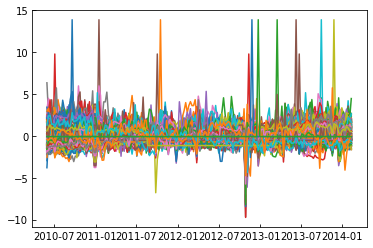

In [58]:
for x in np.array(standardizedts)[12::23,:]:
    pl.plot(rng, x)

In [59]:
len(standardizedts) / 23

333.04347826086956

In [60]:
for x in range(13):
    pl.figure()
    for i in np.arange(standardizedts.shape[0]/13):
        pl.plot(rng, np.array(standardizedts)[23*i + x])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 432x288 with 0 Axes>

## model 3 (not requested at all)

In [61]:
from statsmodels.tsa.stattools import acf
allacf = []
for ts in standardizedts:
    allacf.append(acf(ts))


In [62]:
np.array([[a.params[0] for a in allfits], [a.params[1] for a in allfits], [a.rsquared for a in allfits],
              [np.argmax(a[1:]) for a in allacf], [a[np.argmax(a[1:])] for a in allacf],
              normedtsmean, normedtsstd,
              np.array([(np.max(nts) -  np.min(nts)) for nts in normedtsmean])])

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


array([[-9.41656187e-03, -1.45472894e+00, -1.06906758e+00, ...,
        -8.30556635e-02, -1.16167013e+00, -8.66474156e-01],
       [ 9.75809520e-05,  1.50749113e-02,  1.10784205e-02, ...,
         8.60680451e-04,  1.20380324e-02,  8.97900680e-03],
       [ 2.98635049e-05,  7.12722066e-01,  3.84916355e-01, ...,
         2.32324254e-03,  4.54487234e-01,  2.52852513e-01],
       ...,
       [            inf,             inf,             inf, ...,
         1.04578175e-05,  1.06859373e+00,  1.14116606e-01],
       [            inf,             inf,             inf, ...,
         5.85277692e-04,  1.94659637e+00,  1.25099942e-01],
       [            nan,             nan,             nan, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array([[a.params[0] for a in allfits], [a.rsquared for a in allfits],
              [np.argmax(a[1:]) for a in allacf], [a[np.argmax(a[1:])] for a in allacf],
              normedtsmean, normedtsstd,
              np.array([(np.max(nts) -  np.min(nts)) for nts in normedtsmean])]).T, 
    label, test_size=0.33, random_state=42, shuffle=True)

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [64]:
X_train[~np.isfinite(X_train)] = X_train[np.isfinite(X_train)].mean()
X_test[~np.isfinite(X_test)] = X_test[np.isfinite(X_test)].mean()

In [65]:
clf = rfc()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

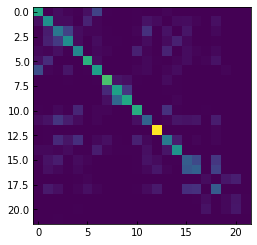

In [66]:
y_pred = clf.predict(X_test)
imshow(confusion_matrix(y_test, y_pred))

In [67]:
print(classification_report(y_test, y_pred, target_names=ridetype))

             precision    recall  f1-score   support

        10t       0.59      0.64      0.62       135
        14d       0.47      0.56      0.51       133
         1d       0.36      0.39      0.37       148
         2t       0.50      0.48      0.49       147
        30d       0.53      0.54      0.53       124
         7d       0.73      0.65      0.68       144
        ada       0.55      0.58      0.56       142
       afas       0.73      0.83      0.78       126
        exp       0.58      0.66      0.62       125
         ez       0.74      0.61      0.67       143
         ff       0.67      0.66      0.67       137
         mc       0.42      0.33      0.37       138
         mr       0.84      0.98      0.90       149
      month       0.47      0.41      0.44       146
        rfm       0.60      0.63      0.62       119
         rr       0.32      0.31      0.32       138
        sen       0.40      0.32      0.35       142
       spec       0.24      0.17      0.20   

//anaconda/envs/GEOP/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 22, does not match size of target_names, 23
  .format(len(labels), len(target_names))


In [68]:
clf.feature_importances_

array([0.26993707, 0.23094423, 0.01977055, 0.02063142, 0.24101369,
       0.21263436, 0.00506869])

Feature ranking:
1. feature  slope (0.269937)
2. feature  normed mean (0.241014)
3. feature  R2 (0.230944)
4. feature  normed std (0.212634)
5. feature  max (0.020631)
6. feature  max location (0.019771)
7. feature  range (0.005069)


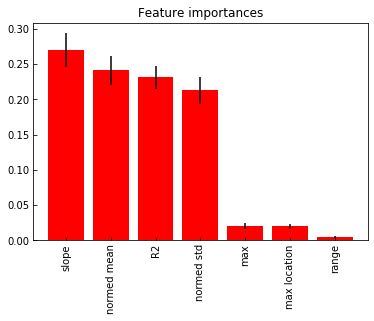

In [69]:
features = ["slope", "R2", "max location", "max", "normed mean", "normed std", "range"]
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(len(clf.feature_importances_)):
    print("%d. feature  %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.figure();
plt.title("Feature importances")
plt.bar(range(len(clf.feature_importances_)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(clf.feature_importances_)), [features[i] for i in indices], rotation=90)
#plt.xlim([-1, X4.shape[1]])
plt.show();
